[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CoolandHot/DATA5709Capstone/blob/main/DATA5709_Capstone_ARIMA.ipynb)

# ARIMA model

In [ ]:
%%capture
# !pip install pmdarima # need to load before pandas
!pip install -U statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os
from matplotlib.dates import DateFormatter


## <font color='yellow'>Load</font> input datasets


In [ ]:
# under "/content/drive/Shareddrives/Education/5709_Capstone/"
!gdown --id "1ltIU2HPfB8OInrCz0d2rV0Up52nPk7Vx"
!gdown --id "1xKa6WDhKfYT0wX-AZV2P0N_YKynOjTJL"

with open("proceeded_pickup.pickle", "rb") as f:
    (taxi_green_demand, taxi_yellow_demand, taxi_uber_demand, taxi_lyft_demand, taxi_via_demand) = pickle.load(f)
with open("proceeded_dropoff.pickle", "rb") as f:
    (taxi_green_supply, taxi_yellow_supply, taxi_uber_supply, taxi_lyft_supply, taxi_via_supply) = pickle.load(f)

taxi_demands = [taxi_green_demand, taxi_yellow_demand, taxi_uber_demand, taxi_lyft_demand, taxi_via_demand]
taxi_supplies = [taxi_green_supply, taxi_yellow_supply, taxi_uber_supply, taxi_lyft_supply, taxi_via_supply]
taxi_names = ["green", "yellow", "uber", "lyft", "via"]

Downloading...
From: https://drive.google.com/uc?id=1ltIU2HPfB8OInrCz0d2rV0Up52nPk7Vx
To: /content/proceeded_dropoff.pickle
141MB [00:01, 125MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xKa6WDhKfYT0wX-AZV2P0N_YKynOjTJL
To: /content/proceeded_pickup.pickle
141MB [00:00, 170MB/s]


_______

## Examinate the data features

Stationarity, Seasonal, Autocorrelation, Partial autocorrelation function, p-value of the model's coefficients


1. ADF :  -19.258911715292577
2. P-Value :  0.0
3. Num Of Lags :  23
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 13224
5. Critical Values :
	 1% :  -3.430844598443207
	 5% :  -2.861758588959801
	 10% :  -2.5668863500012717


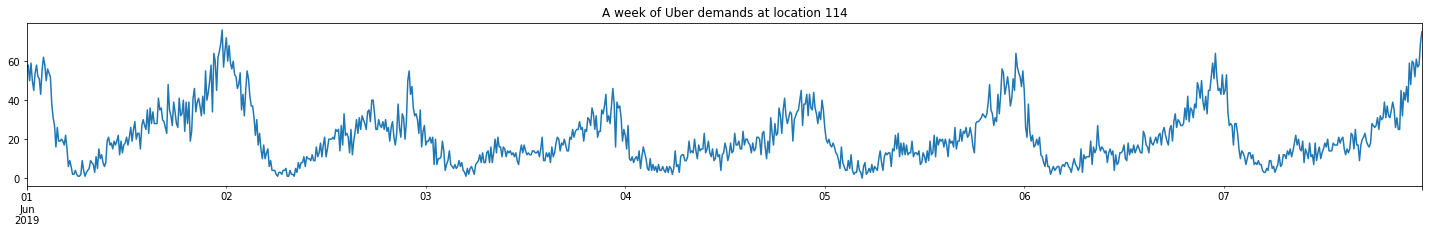

In [ ]:
colNum = 113
oneCycle = 6*24
tmp_series = taxi_uber_demand.iloc[:, colNum]

###########################
# Check For Stationarity
###########################
ax1 = tmp_series[:oneCycle*7].plot(figsize=(25,3), title = 'A week of Uber demands at location '+str(colNum+1))
fig = ax1.get_figure()
fig.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/A week of Uber demands at location "+str(colNum+1)+".svg", bbox_inches='tight')

from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)
      
adf_test(tmp_series)

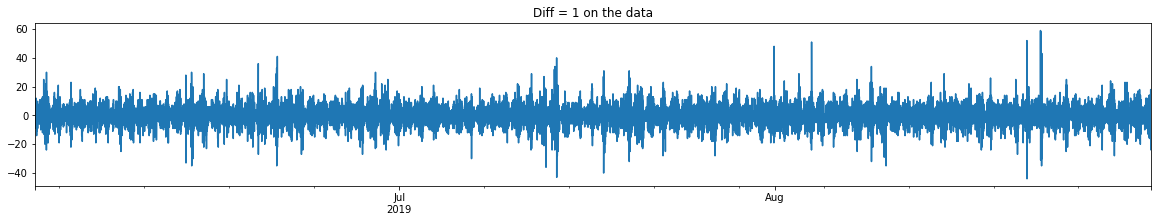

In [ ]:
stationary_df = tmp_series.diff()[1:]
ax1 = stationary_df.plot(figsize=(20,3), title = 'Diff = 1 on the data')
fig = ax1.get_figure()
fig.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/Diff = 1 on the data.svg", bbox_inches='tight')

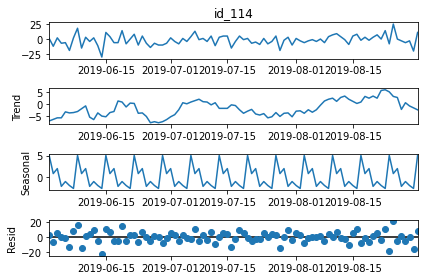

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig = seasonal_decompose(stationary_df.asfreq('D'), model='additive', extrapolate_trend='freq').plot();
# fig.suptitle('Seasonality check')
fig.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/Seasonality check.svg")

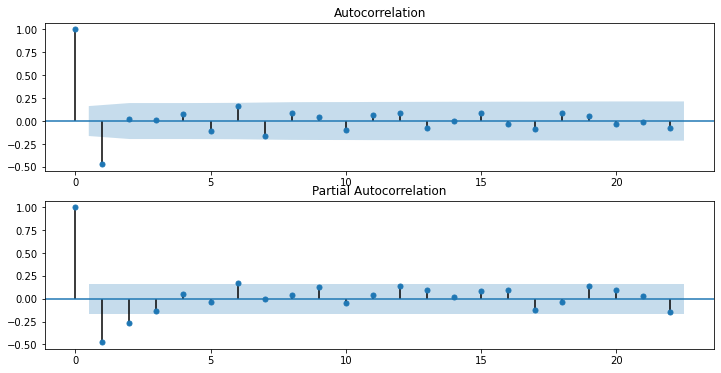

In [ ]:
###########################
# Find the order for ARIMA Model
###########################
# from pmdarima import auto_arima
# print(auto_arima(tmp_series, suppress_warnings=True).summary())


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,6));

ax1 = fig.add_subplot(211)
fig1 = plot_acf(stationary_df[:oneCycle], ax = ax1);

ax2 = fig.add_subplot(212)
fig2 = plot_pacf(stationary_df[:oneCycle], ax = ax2);

fig.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/ACF_PACF.svg", bbox_inches='tight')

In [ ]:
%%time
# ONLY take the last 7 days to predict next one slot, then rolling forecast.
trainset = tmp_series[:oneCycle*7]
testset = tmp_series[oneCycle*7: oneCycle*14]


# ARIMA_model = SARIMAX(trainset, order=(1,1,4), seasonal_order=(1,0,1,oneCycle)).fit()

ARIMA_model = ARIMA(trainset,order=(1,0,2)).fit()

print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 id_114   No. Observations:                 1008
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -3177.832
Date:                Mon, 10 May 2021   AIC                           6365.664
Time:                        12:07:06   BIC                           6390.243
Sample:                    06-01-2019   HQIC                          6375.002
                         - 06-07-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.1620      5.853      4.470      0.000      14.690      37.634
ar.L1          0.9850      0.007    146.138      0.000       0.972       0.998
ma.L1         -0.5576      0.025    -22.216      0.0

# Train and predict at the same time

We take a week's record to predict the next one time frame. Let $[x_0, x_1, ..., x_n]$ denote the time spectrum of a week, $N=6*24*7=1008$ for a 10min window period, with $[x_0, x_1, ..., x_n]$ we can predict the $x_{n+1}$. 

## Train and predict, then save

Determine which locations to use

In [ ]:
########################################################
#### check for which locations hold most volume    #####
########################################################
multiIndex = pd.MultiIndex.from_product([taxi_names, ['demand', 'supply']], names=["vendor", "feature"])
top_locations_pd = pd.DataFrame(columns=multiIndex)

for i, taxi_name in enumerate(taxi_names):
    top_locations_pd.loc[:, (taxi_name, 'demand')] = taxi_demands[i].sum(axis=0).nlargest().astype(str)\
                                                                .reset_index()\
                                                                .agg(': '.join, axis=1)
    top_locations_pd.loc[:, (taxi_name, 'supply')] = taxi_supplies[i].sum(axis=0).nlargest().astype(str)\
                                                                .reset_index()\
                                                                .agg(': '.join, axis=1)
top_locations_pd

vendor           green                 ...            via               
feature         demand         supply  ...         demand         supply
0        id_74: 115226   id_74: 54450  ...  id_140: 75831  id_161: 92461
1         id_75: 87161   id_42: 49867  ...   id_79: 75772  id_140: 68594
2         id_41: 80122   id_41: 44275  ...  id_236: 72854  id_162: 67018
3         id_82: 64944   id_75: 38474  ...  id_239: 69571  id_236: 66848
4          id_7: 59067  id_129: 36718  ...  id_143: 65695  id_239: 62478

[5 rows x 10 columns]

In [ ]:
%%time

train_split_ratio = 0.65
past = 6*24*7 # 7 days

def arimaPred_Save_and_plot(data_df, colNum, taxi_name, pickup_dropoff):
    tmp_df = data_df.iloc[:, colNum-1] # the col_index starts from 0
    feature = 'demand' if pickup_dropoff =="pickup" else 'supply'

    '''trainset and testset are both one week in length'''
    train_split = int(len(tmp_df)*train_split_ratio)
    trainset = tmp_df[train_split:(train_split+past)]
    # try to make sure the testset starts at the same timestamp as LSTM
    testset = tmp_df[(train_split+past):(train_split+past*2)].rename("True value")

    ARIMA_pred = testset.copy().rename("Predicted value")

    for i in range(len(testset)):
        ARIMA_pred[i] = ARIMA(tmp_df[(train_split+i):(train_split+past+i)],order=(1,0,2))\
                        .fit()\
                        .forecast(1)

    with open("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/"+pickup_dropoff+"_prediction_"+taxi_name+"_column"+ str(colNum)+".pkl", "wb") as f:
        pickle.dump((ARIMA_pred, testset), f)

########################################################
####                  Predict                      #####
########################################################
colNums = [37, 41, 61, 74, 75, 79, 138, 265]

for i, taxi_name in enumerate(taxi_names):
    arimaPred_Save_and_plot(taxi_demands[i], colNums[0], taxi_name, 'pickup')
    arimaPred_Save_and_plot(taxi_supplies[i], colNums[0], taxi_name, 'dropoff')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

CPU times: user 2h 19s, sys: 1h 27min 22s, total: 3h 27min 42s
Wall time: 1h 45min 44s
